In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!mkdir potato

In [ ]:
! mkdir ./potato/train
! mkdir ./potato/valid

In [ ]:
! mkdir ./potato/valid/Potato___healthy
! mkdir ./potato/valid/Potato___Late_blight
! mkdir ./potato/valid/Potato___Early_blight

In [ ]:
!rm -rd ./potato/valid

In [ ]:
from distutils.dir_util import copy_tree
import glob
import shutil
dest_dir = "./potato/train/Potato___Early_blight"
for file in glob.glob('/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Potato___Early_blight'):
    print(file)
    copy_tree(file, dest_dir)

In [2]:
# import the necessary libraries
import torch
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import os
import random
import matplotlib.image as mpimg

In [3]:
# store the path of training images in a variable
train_dir = "./potato/train"
# store the path of test images in a variable
val_dir = "./potato/valid"

In [4]:
# compose several transforms of the images together
transform_ds = T.Compose([T.Resize((128, 128)),
                          T.RandomHorizontalFlip(),
                          T.ToTensor()
                         ])

# store the dataset as a subclass of torchvision.datasets
train_ds = torchvision.datasets.ImageFolder(root=train_dir, transform=transform_ds)
val_ds = torchvision.datasets.ImageFolder(root=val_dir, transform=transform_ds)

In [5]:

# check the number of classes of the training set
print('Number of classes of the training set: {} '.format(len(train_ds.classes)))
print('*****************************************')
# check the number of classes of the validation set
print('Number of classes of the validation set: {} '.format(len(val_ds.classes)))

Number of classes of the training set: 3 
*****************************************
Number of classes of the validation set: 3 


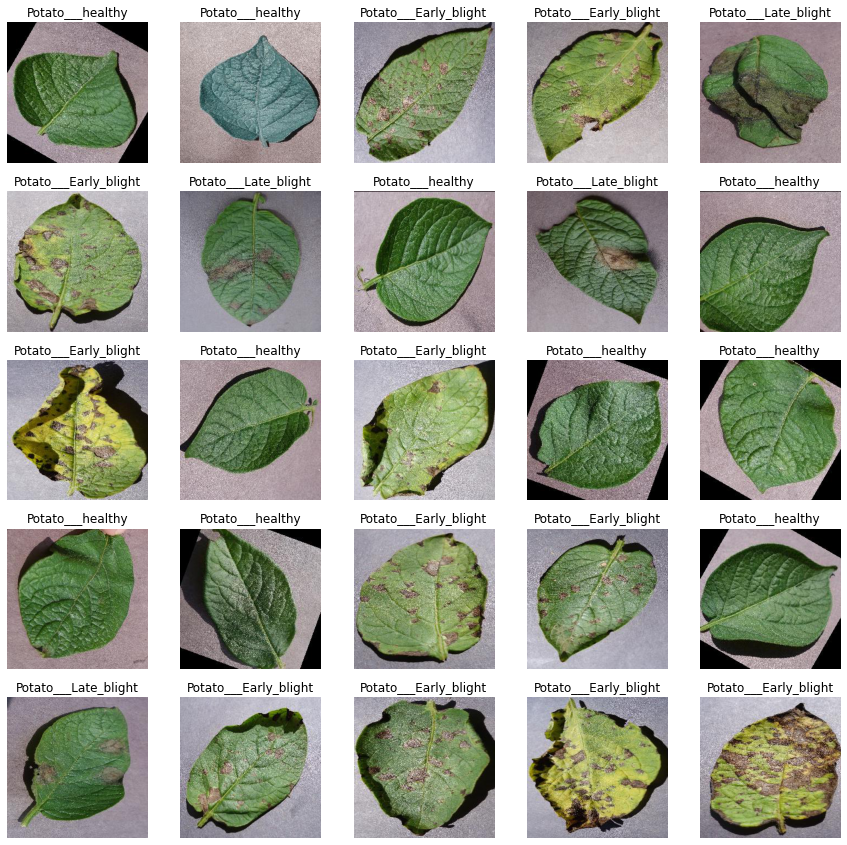

In [6]:

consolidated_path = './potato/train/'

def display_random_birds(ncols=5, ds_path=consolidated_path):
    fig, ax = plt.subplots(ncols=ncols, nrows=ncols, figsize=(15, 15))
    
    for i in range(ncols):
        for j in range(ncols):
            bird_species = random.choice(os.listdir(ds_path))
            random_bird_path = random.choice(os.listdir(ds_path + bird_species))
            random_bird = mpimg.imread(ds_path + bird_species + '/' + random_bird_path)
            ax[i, j].imshow(random_bird)
            ax[i, j].set_title(bird_species)
            ax[i, j].axis('off')
            
display_random_birds()

In [7]:
# create a batch size for the images
batch_size = 128

# Load the dataset from directory in torchvision.datasets
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

In [8]:
# function to get the GPU device
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# function to transfer the data to the GPU device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Class instance to load the data from the GPU device
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
            
    def __len__(self):
        return len(self.dl)

In [9]:

# display the GPU device
device = get_device()
device

device(type='cuda')

In [10]:
# transfer the training set and validation set to the GPU device data loader
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [11]:
# define accuracy function for the model
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [12]:
# create a class instance of the neural network module and the functions involved  
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}
    
    def validation_epoch_end(self, outputs):
        batch_loss = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
    
    def epoch_end(self, epoch, epochs, result):
        print("Epoch: [{}/{}], last_lr: {:.6f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, epochs, result["lrs"][-1], result["train_loss"], result["val_loss"], result["val_acc"]))


In [13]:
# create a class instance of the ResNet18 pretrained model for transfer learning
class model(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.network = models.resnet18(pretrained=True)
        number_of_features = self.network.fc.in_features
        self.network.fc = nn.Linear(number_of_features, num_classes)
        
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.requires_grad= False
        for param in self.network.fc.parameters():
            param.requires_grad= True
        
    def unfreeze(self):
        for param in self.network.parameters():
            param.requires_grad= True


In [ ]:
# ResNet18 model architecture
model = to_device(model(num_classes=3), device)
model

In [ ]:
# disable gradient calculation
@torch.no_grad()

# function for model evaluation
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

# function to get learning rate optimizer
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

# function to fit the training set and validation set into the model
def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=0, grad_clip=None,
                 opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    
    history = []
    
    opt = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs,
                                               steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []
        for batch in tqdm(train_dl):
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            opt.step()
            opt.zero_grad()
            
            lrs.append(get_lr(opt))
            sched.step()
            
        result = evaluate(model, val_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, epochs, result)
        history.append(result)
    return history

In [ ]:
result = [evaluate(model, val_dl)]
result

In [ ]:
epochs = 10
max_lr = 10e-5
grad_clip = 0.1
weight_decay = 10e-4
opt_func = torch.optim.Adam

history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                        weight_decay=weight_decay, 
                        grad_clip=grad_clip,
                        opt_func=opt_func)

In [ ]:
# store test images path into a directory
test_dir = "./potato/valid"

# compose several transforms of the test images together
transform_test = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])

test_ds = torchvision.datasets.ImageFolder(root=test_dir, transform=transform_test)

In [ ]:
# define a funtion to return the model predictions
def prediction(model, images):
    xb = to_device(images.unsqueeze(0), device)
    out = model(xb)
    _, preds = torch.max(out, dim=1)
    predictions = test_ds.classes[preds[0].item()]
    return predictions

In [ ]:
images, labels = test_ds[10]
print("Label: ", test_ds.classes[labels])
print("Prediction: ", prediction(model, images))
plt.imshow(images.permute(1,2,0))

In [ ]:

# validation accuracy
accuracy = [x["val_acc"] for x in history]
plt.plot(accuracy, "-rx")
plt.title("Accuracy vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [ ]:
# train loss and validation loss
val_loss = [x["val_loss"] for x in history]
train_loss = [x.get("train_loss") for x in history]
plt.plot(val_loss, "-bx")
plt.plot(train_loss, "-rx")
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")

In [ ]:
torch.save(model.state_dict(), 'potato.pth')

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import onnx
from onnx_tf.backend import prepare

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [18]:
trained_model = model(num_classes=3)
trained_model.load_state_dict(torch.load('potato.pth'))
dummy_input = Variable(torch.randn(64, 3, 7, 7))
torch.onnx.export(trained_model, dummy_input, "potato.onnx")

In [19]:
model = onnx.load('potato.onnx')
tf_rep = prepare(model) 

In [22]:
# Input nodes to the model
print('inputs:', tf_rep.inputs)

# Output nodes from the model
print('outputs:', tf_rep.outputs)

# All nodes in the model
print('tensor_dict:')
print(tf_rep.tensor_dict)

inputs: ['input.1']
outputs: ['191']
tensor_dict:
{}


In [40]:
tf_rep.export_graph('potato_tensor')

In [ ]:
!tar -czvf potato_model.tar.gz ./potato_tensor